# **Determining Taxi Fare**






The goal of this project is to determine taxi fare based on data gathered from one of the taxi companies I worked for. This analysis aims to understand the various factors that influence taxi fares and to develop a model that can accurately predict fares for future rides.

** important to note that models cannot predict price perfectly because most of the prices are calculated based on live demand.





## Data Collection

The data used in this project was collected from a taxi company over a specified period. The dataset includes the following columns:

1.   **Order time**: The time when the taxi ride was ordered.
2.   **Pickup address**: The address where the ride began.
3.   **Ride price**: The total fare charged for the ride.
4.   **Booking fee**: Additional fee charged for booking the ride.
5.   **Toll fee**: Fee charged for tolls during the ride.
6.   **Cancellation fee**: Fee charged if the ride was canceled.
7.   **Tip**: Additional tip given by the passenger.
8.   **Currency**: The currency in which the fare was paid.
9.   **Payment method**: The method used for payment.
10.  **Payment time**: The time when the payment was made.
11.  **Distance**: The distance covered during the ride.
12. **State**: The current state of the ride (e.g., Finished, Canceled).



## Data Processing

Data provided by taxi company is in csv format which is shown below

In [7]:
from google.colab import drive
drive.mount('/content/drive')

#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import openrouteservice

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from skopt import BayesSearchCV



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install folium
!pip install scikit-optimize
!pip install openrouteservice
!pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
# csv files were manually uploaded csv files to google drive repository taxi_project
# Combined all data to one csv to have a bigger database

directory = '/content/drive/MyDrive/taxi_project'

df_list = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

combined_csv_path = os.path.join(directory, 'combined_taxi_trips.csv')
combined_df.to_csv(combined_csv_path, index=False)

In [ ]:
combined_df.head(3)

,Order time,Pickup address,Ride price,Booking fee,Toll fee,Cancellation fee,Tip,Currency,Payment method,Payment time,Distance,State
0,01.07.2024 23:28,"Bažnyčios gatvė 154349, Domeikava 54349",13.2,0.0,0.0,0.0,0.0,€,Bolt Payment,01.07.2024 23:52,14.66,Finished
1,01.07.2024 23:18,"Baltų pr 105, Kaunas 48207",3.0,0.0,0.0,0.0,0.5,€,Bolt Payment,01.07.2024 23:28,2.32,Finished
2,01.07.2024 23:11,"Tilžės g 8, Каунас 47181",3.8,0.0,0.0,0.0,0.0,€,Bolt Payment,01.07.2024 23:20,2.49,Finished


### Geopraphic coordinates

 Converting addresses to geographic coordinates (latitude and longitude) is crucial for geospatial analysis.

 It allows us to map and analyze locations, calculate distances, and visualize data geographically.

 In this implementation, we use the ArcGIS geocoding service to convert pickup addresses into coordinates.



In [10]:
import pandas as pd
from geopy.geocoders import ArcGIS

geolocator_arcgis = ArcGIS()

csv_file = '/content/drive/MyDrive/taxi_project/combined_taxi_trips.csv'
df = pd.read_csv(csv_file)

def get_coordinates(address):
    location = geolocator_arcgis.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None
df[['Latitude', 'Longitude']] = df['Pickup address'].apply(lambda x: pd.Series(get_coordinates(x)))

print(df)

df.to_csv('/content/drive/MyDrive/taxi_project/taxi_with_arcgis_coordinates.csv', index=False)


           Order time                                 Pickup address  \
0    01.07.2024 23:28        Bažnyčios gatvė 154349, Domeikava 54349   
1    01.07.2024 23:18                     Baltų pr 105, Kaunas 48207   
2    01.07.2024 23:11                       Tilžės g 8, Каунас 47181   
3    01.07.2024 23:04                      Baltų pr 13, Kaunas 48236   
4    01.07.2024 22:45                         Gatvė Ugnės 50, Kaunas   
..                ...                                            ...   
355  21.03.2024 20:24          Plentas Islandijos 9, Kaunas LT-49179   
356  21.03.2024 19:57  Gatvė A. Ir J. Vokietaičių 1, Kaunas LT-50181   
357  21.03.2024 19:43         Gatvė K. Petrausko 30, Kaunas LT-44162   
358  21.03.2024 19:08                         Prancūzų g 159, Kaunas   
359  21.03.2024 18:35             Gatvė Vytenio 10, Κάουνας LT-48421   

     Ride price  Booking fee  Toll fee  Cancellation fee  Tip Currency  \
0          13.2          0.0       0.0               0.0  0.0

Using the Folium library, coordinates are visualized on a real-life map.

In [ ]:

map_center = [df_filtered['Latitude'].mean(), df_filtered['Longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

for idx, row in df_filtered.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Pickup address'],
    ).add_to(mymap)
mymap

 We will delete rows where there is no significant difference in the values and geo algorithm didn't extract coordinates from address.

  And delete or not use columns intuivetely where those variables would pay a role in determening ride price ( e.g. tip shouldn't affect ride price which was calculated by taxi company algorithm)


As it is shown there are some geocoding errors as all rides were taken inside Kaunas
* Forum cinemas, Akropolis (in Vilnius)
* Uosių g 8, Kaišiadorių rajono savivaldybė
* Draugystės g 2, Каунас
* Gatvė S. Nėries 15, Kaunas
* Neries g 22, Kaunas
* Kauno geležinkelio stotis, Kauno geležinkelio stotis
*Roundabout, Hospital of Lithuanian University of Health Sciences
* Išėjimas (nulinis aukštas), Žalgirio arena
* Ežero g 3
* Griundvaldo g., Akropolis
* Centrinis įėjimas, Mega
* Exit (ground floor), Žalgirio arena
* Kaunas Railway station, Kaunas Railway Station




I have decided to remove rows containing those addresses but to save more data those could be converted to correct ones (e.g."Centrinis įėjimas, Mega" = "Islandijos pl. 32, Kaunas, 47446 Kauno m. sav.")

In [177]:
import pandas as pd
import folium

csv_file = '/content/drive/MyDrive/taxi_project/taxi_with_arcgis_coordinates.csv'
df = pd.read_csv(csv_file)

incorrect_addresses = [
    "Forum cinemas, Akropolis",
    "Uosių g 8, Kaišiadorių rajono savivaldybė",
    "Rimi išėjimas, Mega",
    "Draugystės g 2, Каунас",
    "Rimi išėjimas, Mega",
    "Gatvė S. Nėries 15, Kaunas",
    "Neries g 22, Kaunas",
    "Kauno geležinkelio stotis, Kauno geležinkelio stotis",
    "Roundabout, Hospital of Lithuanian University of Health Sciences",
    "Išėjimas (nulinis aukštas), Žalgirio arena",
    "Ežero g 3",
    "Griundvaldo g., Akropolis",
    "Centrinis įėjimas, Mega",
    "Exit (ground floor), Žalgirio arena",
    "Kaunas Railway station, Kaunas Railway Station"
]

# Drop rows with incorrect addresses
df_filtered = df[~df['Pickup address'].isin(incorrect_addresses)]

# "Rimi išėjimas, Mega" row wasn't dropped, and from the map it can be seen that arcgis located it in Africa (below Lithuania).
# Drop rows where Latitude is below the southernmost point of Lithuania (54.3833 N).

df_filtered = df_filtered[df_filtered['Latitude'] >= 54.3833]

map_center = [df_filtered['Latitude'].mean(), df_filtered['Longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

for idx, row in df_filtered.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Pickup address'],
    ).add_to(mymap)

mymap
# Save the df_filtered DataFrame to a CSV file
df_filtered.to_csv('/content/drive/MyDrive/taxi_project/taxi_filtered.csv', index=False)



### Data cleaning

Next step is to count unique values for variables such as

* Payment method
* State
* Booking fee
* Toll fee
* Cancellation fee
* Tip
* Currency
  

In [178]:
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'

df = pd.read_csv(csv_file)

payment_method_counts = df['Payment method'].value_counts()
num_unique_payment_method = df['Payment method'].nunique()

state_counts = df['State'].value_counts()
num_unique_states = df['State'].nunique()

currency_counts = df['Currency'].value_counts()
num_unique_currency = df['Currency'].nunique()

booking_fee_counts = df['Booking fee'].value_counts()
num_unique_booking_fee = df['Booking fee'].nunique()

toll_fee_counts = df['Toll fee'].value_counts()
num_unique_toll_fee = df['Toll fee'].nunique()

cancellation_fee_counts = df['Cancellation fee'].value_counts()
num_unique_cancellation_fee = df['Cancellation fee'].nunique()

tip_counts = df['Tip'].value_counts()
num_unique_tip = df['Tip'].nunique()

print("Counts of each unique value in the 'Payment method' column:")
print(payment_method_counts)


print("Counts of each unique value in the 'State' column:")
print(state_counts)


print("\nCounts of each unique value in the 'Booking fee' column:")
print(booking_fee_counts)

print("\nCounts of each unique value in the 'Toll fee' column:")
print(toll_fee_counts)

print("\nCounts of each unique value in the 'Cancellation fee' column:")
print(cancellation_fee_counts)

print("\nCounts of each unique value in the 'Tip' column:")
print(tip_counts)

print("\nCounts of each unique value in the 'Currency' column:")
print(currency_counts)


Counts of each unique value in the 'Payment method' column:
Payment method
Bolt Payment    242
Cash             95
Name: count, dtype: int64
Counts of each unique value in the 'State' column:
State
Finished            336
Client cancelled      1
Name: count, dtype: int64

Counts of each unique value in the 'Booking fee' column:
Booking fee
0.0    337
Name: count, dtype: int64

Counts of each unique value in the 'Toll fee' column:
Toll fee
0.0    337
Name: count, dtype: int64

Counts of each unique value in the 'Cancellation fee' column:
Cancellation fee
0.0    336
4.0      1
Name: count, dtype: int64

Counts of each unique value in the 'Tip' column:
Tip
0.0    311
0.5     11
1.0     10
3.0      4
6.0      1
Name: count, dtype: int64

Counts of each unique value in the 'Currency' column:
Currency
€    337
Name: count, dtype: int64


**Removing rows where passenger cancelled and Booking fee is not 0, and cancelattion fee is not 0.**

In [179]:
import pandas as pd

csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

rows_before = df.shape[0]

df_filtered = df[~((df['State'] == 'Client cancelled') | (df['Booking fee'] != 0) | (df['Cancellation fee'] != 0))]
rows_after = df_filtered.shape[0]

# Print the number of rows before and after filtering
print(f"\nNumber of rows before filtering: {rows_before}")
print(f"Number of rows after filtering: {rows_after}")

df_filtered.to_csv(csv_file, index=False)



Number of rows before filtering: 337
Number of rows after filtering: 336


In [180]:
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

df['Order time'] = pd.to_datetime(df['Order time'], format='%d.%m.%Y %H:%M')
df['Payment time'] = pd.to_datetime(df['Payment time'], format='%d.%m.%Y %H:%M')
df['time_difference'] = (df['Payment time'] - df['Order time']).dt.total_seconds() / 60

# searching for outlieries time difference greater than 60 minutes
# drop rows where time_difference is greater than 60 minutes

df_filtered = df[df['time_difference'] > 60]
print(df_filtered)

df.drop(df_filtered.index, inplace=True)

df.to_csv(csv_file, index=False)

             Order time        Pickup address  Ride price  Booking fee  \
202 2024-04-10 21:03:00  Raudondvario pl 284A         4.5          0.0   

     Toll fee  Cancellation fee  Tip Currency Payment method  \
202       0.0               0.0  0.0        €   Bolt Payment   

           Payment time  Distance     State  Latitude  Longitude  \
202 2024-04-11 22:17:00      4.34  Finished  54.93814   23.77999   

     time_difference  
202           1514.0  


# Feature engineering

In the feature engineering section of this notebook, we will perform the following transformations and enhancements on our dataset:

1. **Cyclic Transformation of Date and Time:**

* We will convert the 'Order time' feature into cyclic components using sine and cosine transformations. This allows the model to capture the periodic nature of time (e.g., hourly, daily or weekly cycles).
2. **Geospatial Feature Engineering:**

 Using the coordinates (latitude and longitude), we will explore different approaches to enhance the spatial information. This includes:
* **Clustering Methods**: Grouping data points into clusters to capture regional effects. ( **DBSCAN** and **K-means**)

* **Polar Coordinates**: Transforming latitude and longitude into polar coordinates for an alternative spatial representation.
These transformations and feature engineering techniques aim to improve the model's ability to understand and predict the taxi fare based on time and location data.

3. **Encoding Categorical variables**
* We will apply one-hot encoding to categorical variables such as '**Payment method**'

4. **Time Difference calculation**
We will create a **time_difference** feature representing the duration in minutes between **Payment time** and** Order time**. This feature captures the time elapsed between the two events.

## Cyclic transformation of date and time

In [45]:
def extract_date_features(data):
    data['Order time'] = pd.to_datetime(df['Order time'], format='%Y-%m-%d %H:%M:%S')
    data["day"] = data['Order time'].dt.day
    data["month"] = data['Order time'].dt.month
    data['day_of_week'] = data['Order time'].dt.dayofweek.astype(int)
    data['hour'] = data['Order time'].dt.hour
    data['hour+min'] = data['Order time'].dt.hour + data['Order time'].dt.minute / 60
    data['minute'] = data['Order time'].dt.minute

    # Cyclic transformation
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
    data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['hour_sin'] = np.sin(2 * np.pi * data['hour+min'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour+min'] / 24)

    return data


In [183]:
# Applying cyclic transformation to dataframe and saving it in the same csv
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

df_with_features = extract_date_features(df)

df_with_features.to_csv(csv_file, index=False)

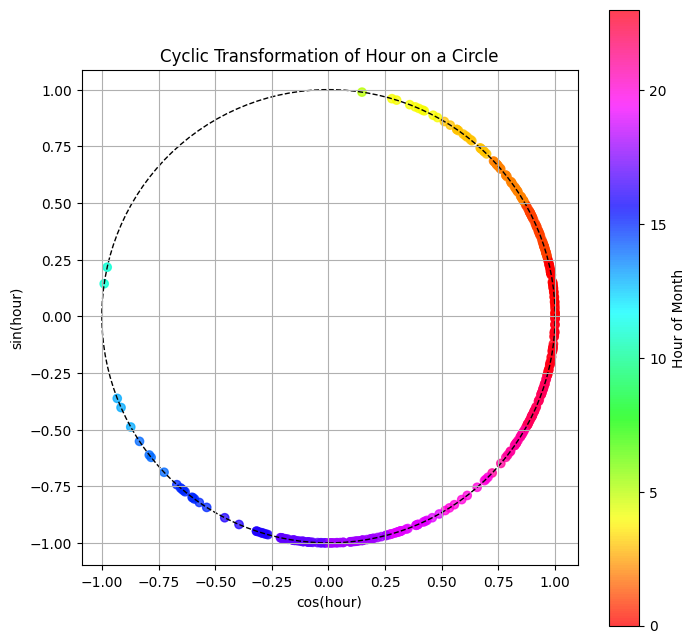

In [184]:
# Visualization of the cyclic transformation of hours of the day on a circle
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

required_columns = ['hour_cos', 'hour_sin', 'hour']

plt.figure(figsize=(8, 8))
plt.scatter(df['hour_cos'], df['hour_sin'], c=df['hour'], cmap='hsv', alpha=0.75)
plt.colorbar(label='Hour of Month')
plt.xlabel('cos(hour)')
plt.ylabel('sin(hour)')
plt.title('Cyclic Transformation of Hour on a Circle')

circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)
plt.show()


## Geospatial feature engineering

### Clustering method K-Means

In [185]:
import pandas as pd
from sklearn.cluster import KMeans
import folium
from IPython.display import display

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/taxi_project/taxi_filtered.csv')

# Ensure Latitude and Longitude are float
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Perform K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust the number of clusters as needed
df['Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Define a list of colors for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
          'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
          'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add clustered points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_color=colors[row['Cluster'] % len(colors)],
        fill_opacity=0.6
    ).add_to(m)

# Display the map
display(m)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Hierarchy clustering (agglomerative)

In [186]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df = pd.read_csv('/content/drive/MyDrive/taxi_project/taxi_filtered.csv')

# Normalize the data
scaler = StandardScaler()
df[['Latitude', 'Longitude']] = scaler.fit_transform(df[['Latitude', 'Longitude']])
coords = df[['Latitude', 'Longitude']].values

# Perform Agglomerative Clustering
n_clusters = 20  # Choosing number of clusters
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = hierarchical.fit_predict(coords)

mean_lat = scaler.inverse_transform([[df['Latitude'].mean(), df['Longitude'].mean()]])[0][0]
mean_lon = scaler.inverse_transform([[df['Latitude'].mean(), df['Longitude'].mean()]])[0][1]
base_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=8)

cmap = plt.colormaps['tab10']

def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

# Plot clusters
for _, row in df.iterrows():
    lat = scaler.inverse_transform([[row['Latitude'], row['Longitude']]])[0][0]
    lon = scaler.inverse_transform([[row['Latitude'], row['Longitude']]])[0][1]
    cluster = int(row['Cluster'])
    color = rgb_to_hex(cmap(cluster / n_clusters))
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f'Cluster: {cluster}'
    ).add_to(base_map)

base_map


### Pickup coordinates transformation to 3-D

In [198]:
import pandas as pd
import numpy as np

csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

df['Latitude_rad'] = np.radians(df['Latitude'])
df['Longitude_rad'] = np.radians(df['Longitude'])

# Calculate the 3-dimensional coordinates
df['pickup_x'] = np.cos(df['Latitude_rad']) * np.cos(df['Longitude_rad'])
df['pickup_y'] = np.cos(df['Latitude_rad']) * np.sin(df['Longitude_rad'])
df['pickup_z'] = np.sin(df['Latitude_rad'])


pickup_x_min, pickup_x_max = df['pickup_x'].min(), df['pickup_x'].max()
pickup_y_min, pickup_y_max = df['pickup_y'].min(), df['pickup_y'].max()
pickup_z_min, pickup_z_max = df['pickup_z'].min(), df['pickup_z'].max()

print(f"Interval for pickup_x: [{pickup_x_min}, {pickup_x_max}]")
print(f"Interval for pickup_y: [{pickup_y_min}, {pickup_y_max}]")
print(f"Interval for pickup_z: [{pickup_z_min}, {pickup_z_max}]")
df.to_csv(csv_file, index=False)


Interval for pickup_x: [0.524210727465671, 0.5264270230077222]
Interval for pickup_y: [0.2319187224045528, 0.23415483130064285]
Interval for pickup_z: [0.8175101957525276, 0.8190314622017091]


## Encoding Categorical variables

In [196]:
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

df = pd.get_dummies(df, columns=['Payment method'], prefix='payment_method')

df.to_csv(csv_file, index=False)

KeyError: "None of [Index(['Payment method'], dtype='object')] are in the [columns]"

## Creating new column (time difference)

In [189]:
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

df['Order time'] = pd.to_datetime(df['Order time'], format='%Y-%m-%d %H:%M:%S')
df['Payment time'] = pd.to_datetime(df['Payment time'], format='%Y-%m-%d %H:%M:%S')
df['time_difference'] = (df['Payment time'] - df['Order time']).dt.total_seconds() / 60

df.to_csv(csv_file, index=False)

# Model training

Price prediction is a regression problem. To address this, we will use regression algorithms such as:

* **XGBoost**: A gradient boosting algorithm known for handling complex patterns and improving predictions iteratively.
* **Random Forest**: An ensemble method that leverages multiple decision trees to manage non-linear relationships and reduce overfitting.

To assess model accuracy, we will use popular metrics:
* **RMSE**
* **R^2**

## Naive approach

Use the mean value of the target variable from the training set as the constant prediction for all instances in both the training and testing sets.

In [190]:
csv_file_path = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file_path)

# choosing any feature since we will only use target for evaluating rmse
features = 'day_sin'
target = 'Ride price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Computing the mean of training target values
train_mean = y_train.mean()

# Create predictions with the mean value
train_preds = [train_mean] * len(y_train)
valid_preds = [train_mean] * len(y_test)

# Define a function to calculate metrics
def metrics(train_preds, valid_preds, y_train, y_valid):
    train_preds = np.array(train_preds)
    valid_preds = np.array(valid_preds)

    tr_rmse = mean_squared_error(y_train, train_preds, squared=False)
    vr_rmse = mean_squared_error(y_valid, valid_preds, squared=False)

    tr_mape = mean_absolute_error(y_train, train_preds) / y_train.mean() * 100
    vr_mape = mean_absolute_error(y_valid, valid_preds) / y_valid.mean() * 100

    tr_r2 = r2_score(y_train, train_preds)
    vr_r2 = r2_score(y_valid, valid_preds)

    return tr_rmse, vr_rmse, tr_mape, vr_mape, tr_r2, vr_r2

tr_rmse, vr_rmse, tr_mape, vr_mape, tr_r2, vr_r2 = metrics(train_preds, valid_preds, y_train, y_test)

print(f'Training RMSE: {tr_rmse:.2f}')
print(f'Validation RMSE: {vr_rmse:.2f}')
print(f'Training MAPE: {tr_mape:.2f}%')
print(f'Validation MAPE: {vr_mape:.2f}%')
print(f'Training R^2: {tr_r2:.2f}')
print(f'Validation R^2: {vr_r2:.2f}')


Training RMSE: 3.70
Validation RMSE: 4.47
Training MAPE: 40.21%
Validation MAPE: 43.56%
Training R^2: 0.00
Validation R^2: -0.00


## Random Forest naive approach

Random Forest Naive Approach
RMSE: 2.35
R^2: 0.72


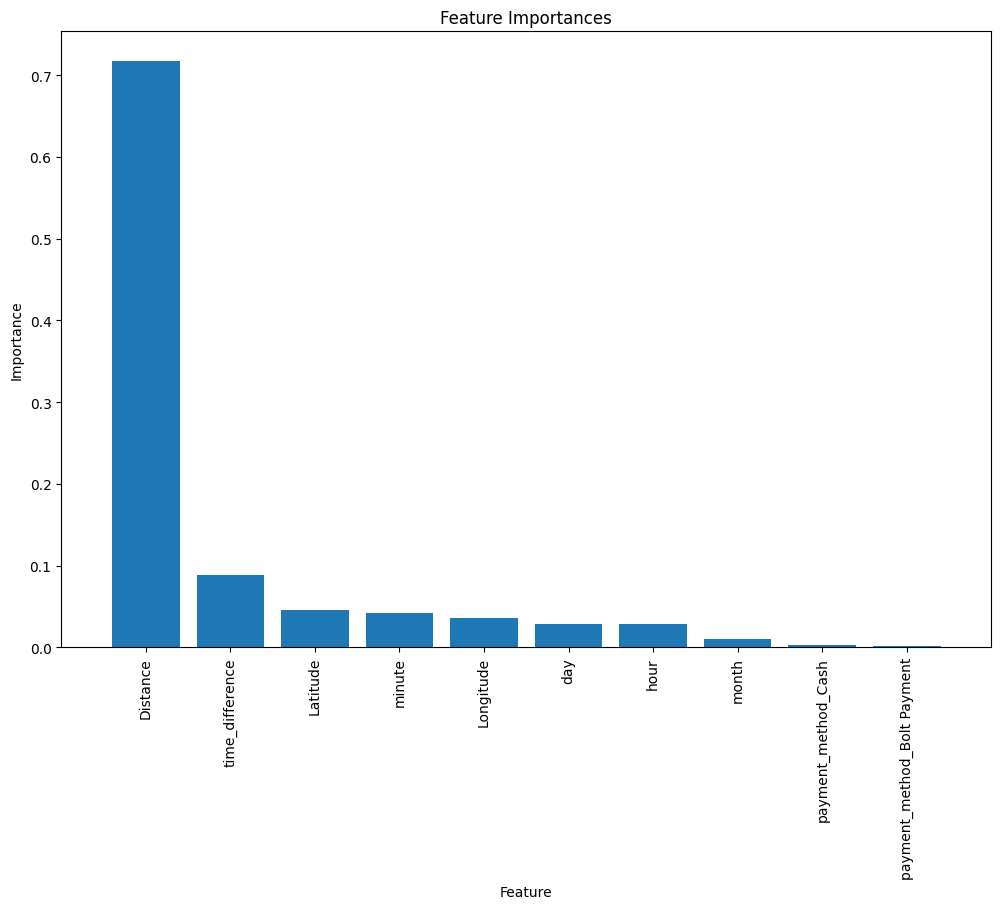

In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

# Defining features for which no cyclic or geospatial transformation were done
features = ['day', 'month', 'hour', 'minute', 'time_difference', 'Distance', 'Longitude', 'Latitude',
             'payment_method_Bolt Payment', 'payment_method_Cash']
target = 'Ride price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Calculate RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Random Forest Naive Approach')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## Random forest regressor with feature engineering (K-means clustering)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Random Forest with K-means clustering
RMSE: 2.25
R^2: 0.75


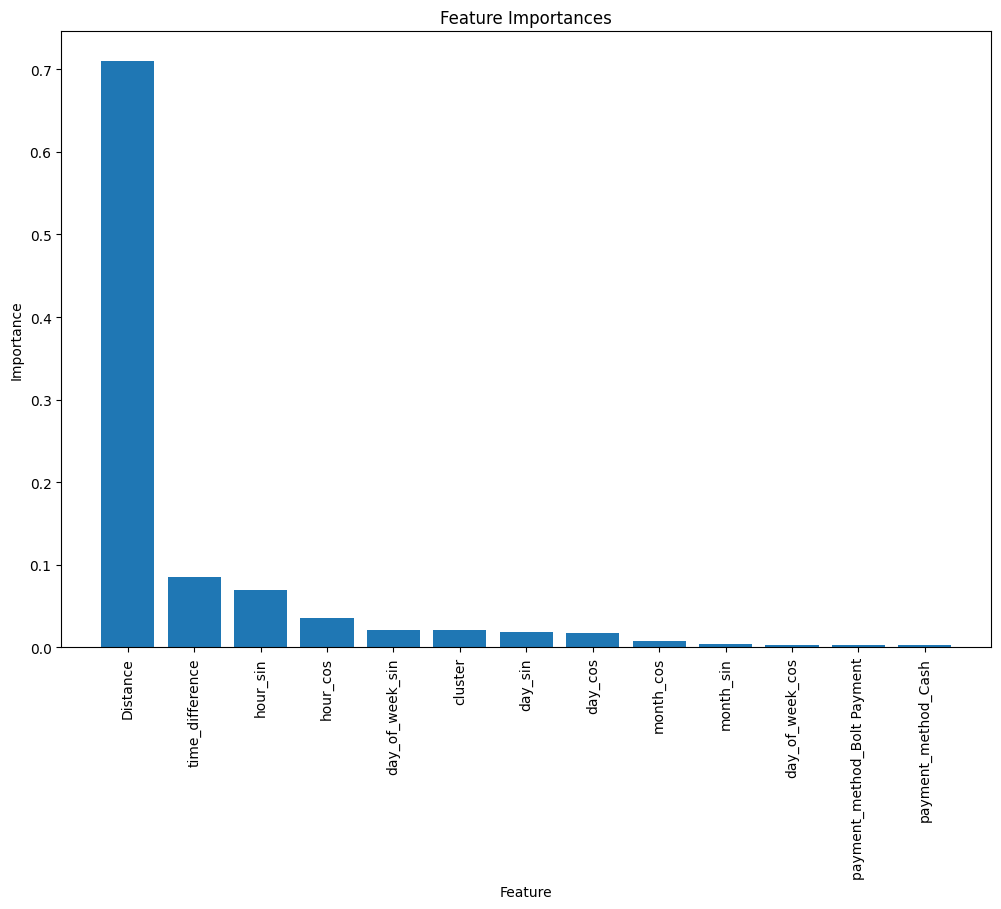

In [192]:
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Latitude', 'Longitude']])

kmeans = KMeans(n_clusters=8, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

df = df.dropna(subset=['cluster'])

features = ['day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
             'hour_sin', 'hour_cos', 'time_difference', 'Distance', 'cluster',
             'payment_method_Bolt Payment', 'payment_method_Cash']
target = 'Ride price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Random Forest with K-means clustering')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## Random Forest Regressor with Agglomerative Hierarchical clustering

Random Forest with Agglomerative Hierarchical clustering
RMSE: 2.19
R^2: 0.76


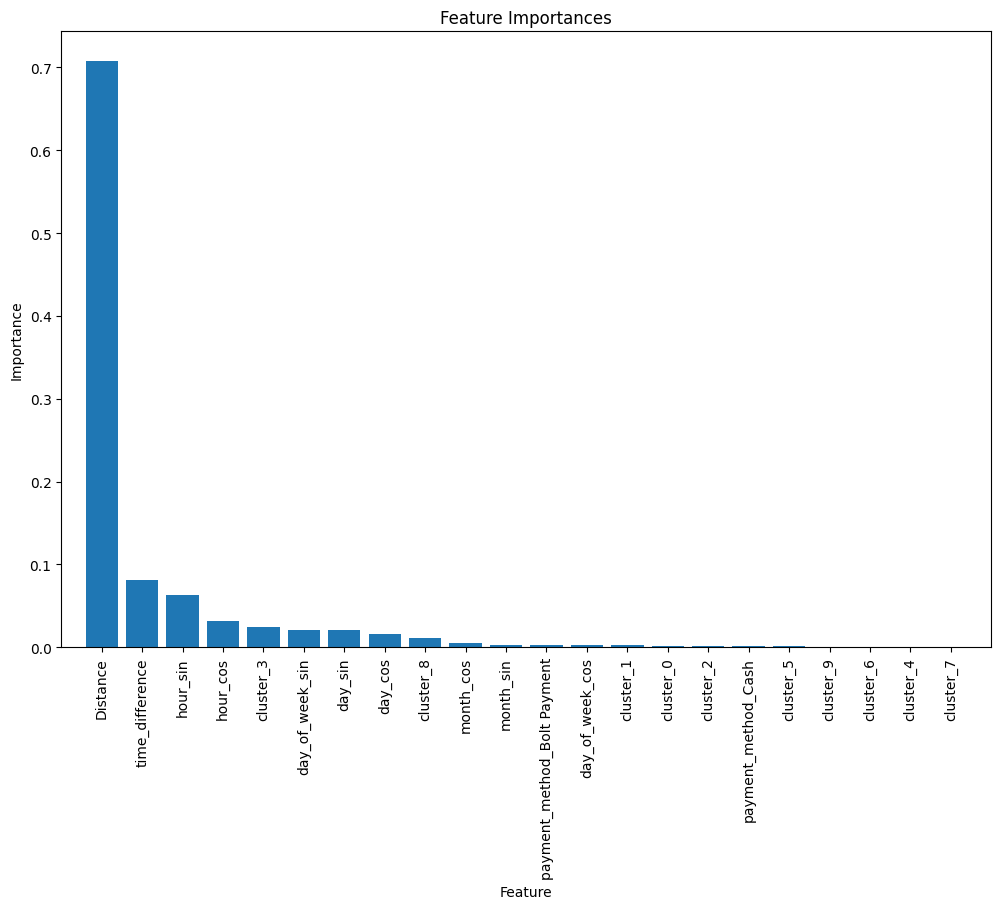

In [193]:
df = pd.read_csv('/content/drive/MyDrive/taxi_project/taxi_filtered.csv')

scaler = StandardScaler()
df[['Latitude', 'Longitude']] = scaler.fit_transform(df[['Latitude', 'Longitude']])
coords = df[['Latitude', 'Longitude']].values

# Perform Agglomerative Clustering
n_clusters = 10
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = hierarchical.fit_predict(coords)

df = pd.get_dummies(df, columns=['Cluster'], prefix='cluster')

features = ['day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
             'hour_sin', 'hour_cos', 'time_difference', 'Distance'] + [col for col in df.columns if col.startswith('cluster_')] + \
             ['payment_method_Bolt Payment', 'payment_method_Cash']
target = 'Ride price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f'Random Forest with Agglomerative Hierarchical clustering')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


## Random Forest Regressor with latitude and longitude transformation to 3-D

Random Forest with Agglomerative Hierarchical clustering
RMSE: 2.33
R^2: 0.73


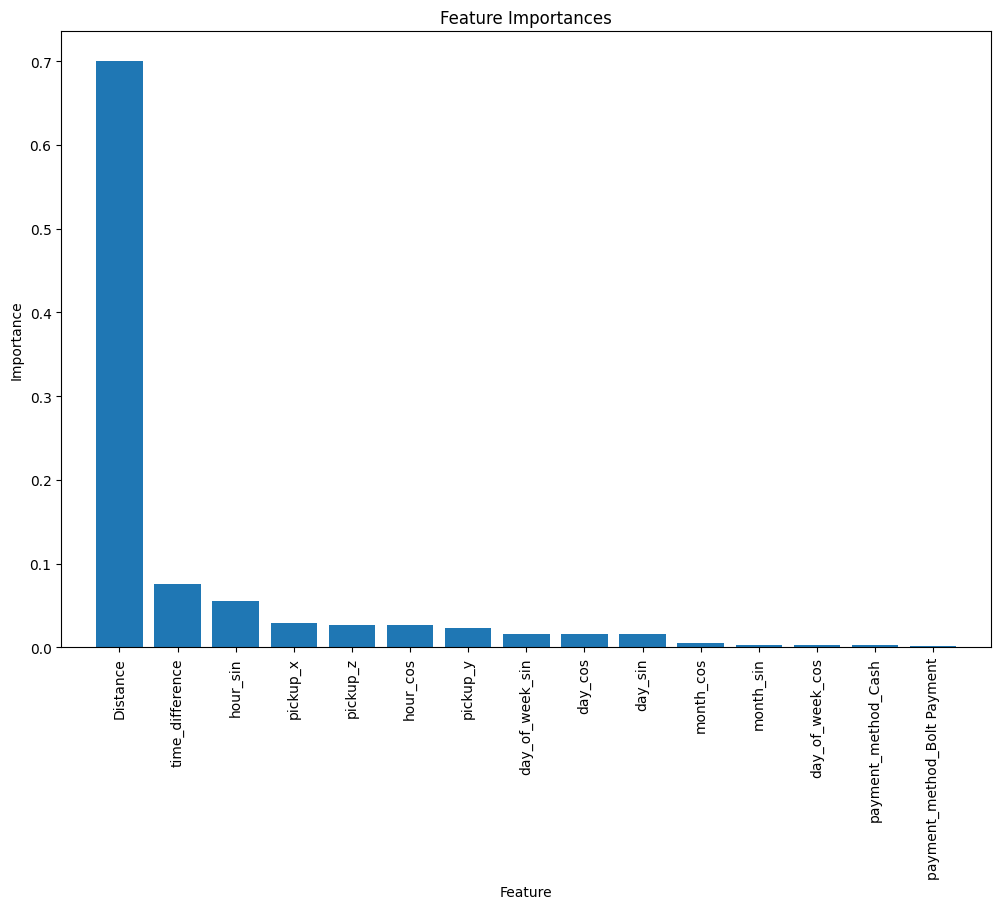

In [199]:
df = pd.read_csv('/content/drive/MyDrive/taxi_project/taxi_filtered.csv')


# Define features and target
features = ['day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
             'hour_sin', 'hour_cos', 'time_difference', 'Distance'] + ['pickup_x','pickup_z','pickup_y'] + \
             ['payment_method_Bolt Payment', 'payment_method_Cash']
target = 'Ride price'

# Prepare features and target arrays
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Calculate RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Random Forest with Agglomerative Hierarchical clustering')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## XGBoost with default settings (no geospatial transformations)

XGBoost Model with Default Parameters
RMSE: 2.82
R^2: 0.60


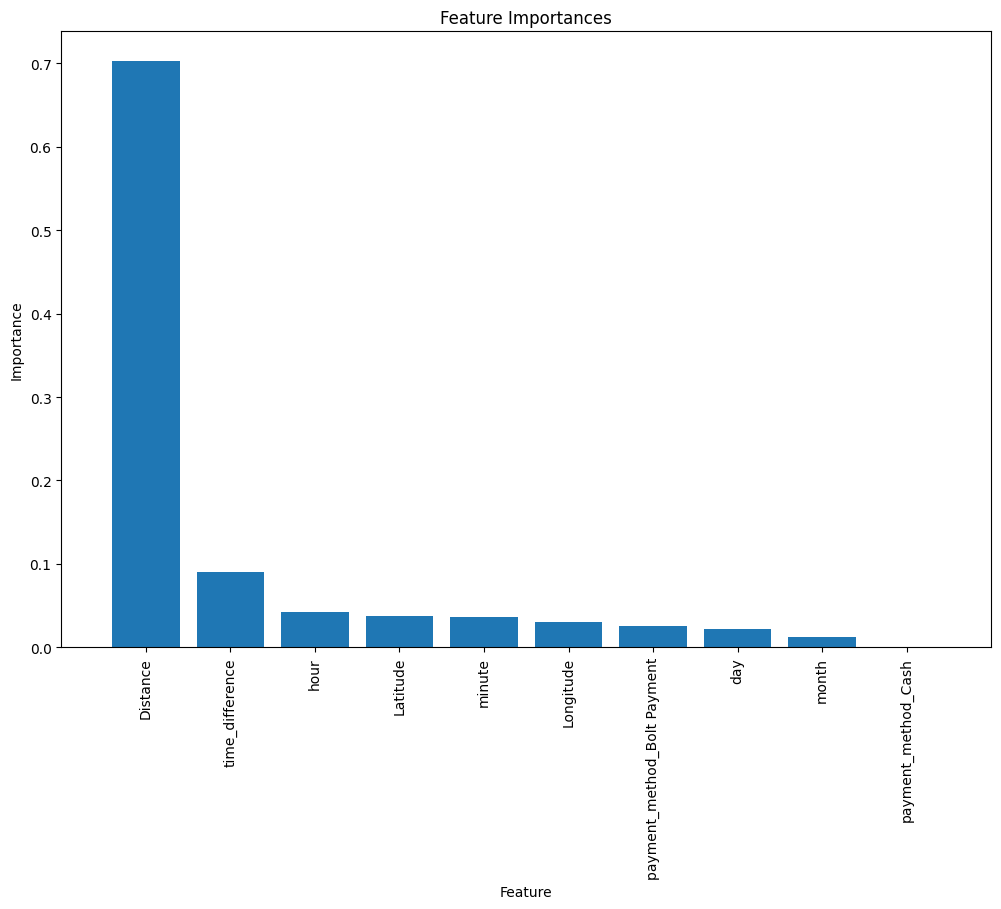

In [150]:
df = pd.read_csv('/content/drive/MyDrive/taxi_project/taxi_filtered.csv')

features = ['day', 'month', 'hour', 'minute', 'time_difference', 'Distance', 'Longitude', 'Latitude',
             'payment_method_Bolt Payment', 'payment_method_Cash']
target = 'Ride price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

# Calculate and print RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'XGBoost Model with Default Parameters')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Feature importances
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## XGBoost (K-means clustering and time cyclic transformation)

XGBoost Model with K-means Clustering
RMSE: 2.63
R^2: 0.65


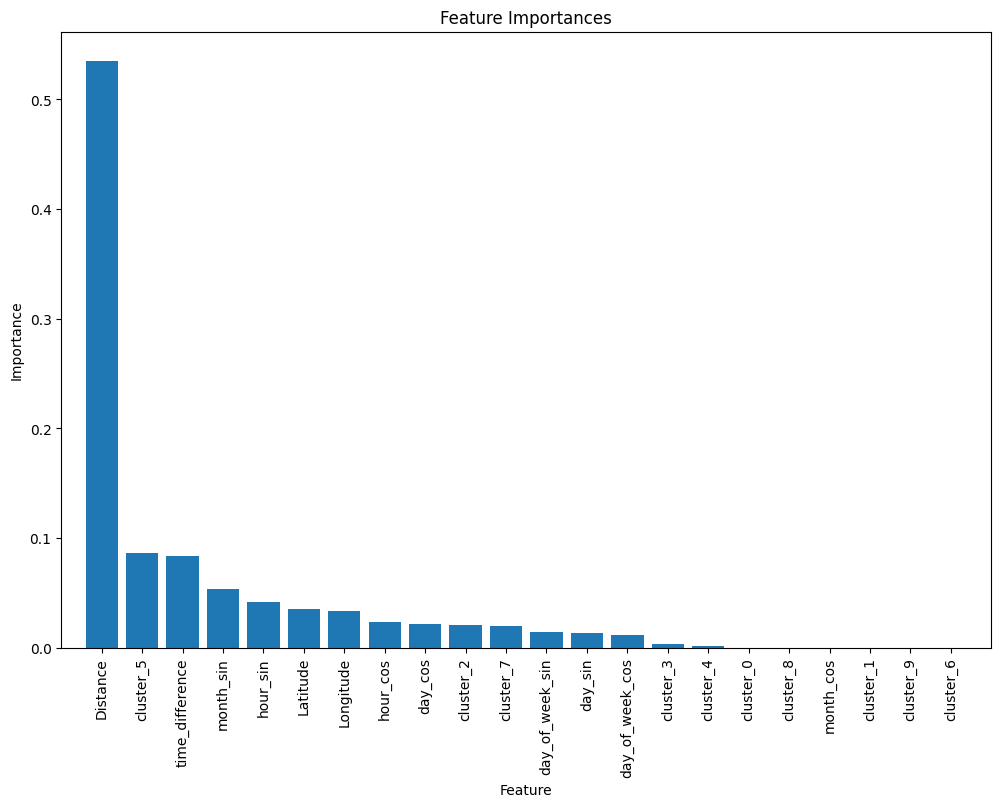

In [162]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

df = df.dropna(subset=['Latitude', 'Longitude'])

scaler = StandardScaler()
df[['Latitude', 'Longitude']] = scaler.fit_transform(df[['Latitude', 'Longitude']])
coords = df[['Latitude', 'Longitude']].values

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(coords)

encoder = OneHotEncoder(categories=[range(n_clusters)], drop=None, sparse_output=False)
cluster_encoded = encoder.fit_transform(df[['cluster']])
cluster_encoded_df = pd.DataFrame(cluster_encoded, columns=[f'cluster_{i}' for i in range(n_clusters)])

df = df.reset_index(drop=True)
df = pd.concat([df, cluster_encoded_df], axis=1)

features = ['day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
             'hour_sin', 'hour_cos', 'time_difference', 'Distance', 'Latitude', 'Longitude'] + [f'cluster_{i}' for i in range(n_clusters)]
target = 'Ride price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'XGBoost Model with K-means Clustering')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


In [69]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.1 MB/s eta 0:00:00


In [ ]:
pip install skopt

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


In [ ]:
from skopt import BayesSearchCV

ModuleNotFoundError: No module named 'skopt'

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV

# Load your dataset
csv_file = '/content/drive/MyDrive/taxi_project/processed_data_with_coordinates.csv'
df = pd.read_csv(csv_file)



# Perform KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

# Drop rows with missing clusters
df = df.dropna(subset=['cluster'])

# Drop rows with missing clusters
df = df.dropna(subset=['cluster'])
# Define features and target variable
features = ['time_in_minutes', 'Distance', 'time_difference','cluster'] + [col for col in df.columns if 'day_' in col]
target = 'Ride price'
# Define features and target variable


X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for Bayesian search
param_grid = {
    'n_estimators': (50, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': (5, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize the BayesSearchCV object
bayes_search = BayesSearchCV(estimator=rf, search_spaces=param_grid, n_iter=50, cv=3, n_jobs=-1, random_state=42)

# Fit the Bayesian search model
bayes_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", bayes_search.best_params_)

# Train the Random Forest model with the best parameters
best_rf = bayes_search.best_estimator_
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f'Random Forest Root Mean Squared Error with Clusters: {rmse_rf:.2f}')

# Optional: Print feature importance
print("\nFeature Importances:")
for feature, importance in zip(features, best_rf.feature_importances_):
    print(f"{feature}: {importance:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found:  OrderedDict([('bootstrap', True), ('max_depth', 50), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 11), ('n_estimators', 264)])


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest Root Mean Squared Error with Clusters: 2.32

Feature Importances:
time_in_minutes: 0.0333
Distance: 0.7589
time_difference: 0.1792
cluster: 0.0082
day_0: 0.0010
day_1: 0.0000
day_2: 0.0010
day_3: 0.0061
day_4: 0.0012
day_5: 0.0097
day_6: 0.0014


In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
features = ['hour', 'minute','time_difference', 'day_of_week', 'Distance', 'cluster']
target = 'Ride price'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Train the Random Forest model with the best parameters
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f'Random Forest Root Mean Squared Error with Clusters: {rmse_rf:.2f}')

# Optional: Print feature importance
print("\nFeature Importances:")
for feature, importance in zip(features, best_rf.feature_importances_):
    print(f"{feature}: {importance:.4f}")


KeyError: "['hour', 'minute', 'day_of_week'] not in index"

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
df=df_filtered
df = df.dropna()
# Convert 'Order time' and 'Payment time' to datetime format
df['Order time'] = pd.to_datetime(df['Order time'], format='%d.%m.%Y %H:%M')
df['Payment time'] = pd.to_datetime(df['Payment time'], format='%d.%m.%Y %H:%M')
df['hour'] = df['Order time'].dt.hour
# Calculate the time difference in minutes
df['time_difference'] = (df['Payment time'] - df['Order time']).dt.total_seconds() / 60

# Extract datetime features and combine hour and minute
df['time_in_minutes'] = df['Order time'].dt.hour * 60 + df['Order time'].dt.minute
df['day_of_week'] = df['Order time'].dt.dayofweek

df = pd.get_dummies(df, columns=['day_of_week'], prefix='day')

# Scale the data for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Latitude', 'Longitude']])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

# Drop rows with missing clusters
df = df.dropna(subset=['cluster'])

# Define features and target variable
features = ['Distance', 'cluster', 'time_difference'] + [col for col in df.columns if 'day_' in col]
target='Ride price'
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean] * len(y_train)
valid_preds = [train_mean] * len(y_test)

# Define a function to calculate metrics
def metrics(train_preds, valid_preds, y_train, y_valid):
    tr_rmse = mean_squared_error(y_train, train_preds, squared=False)  # RMSE for training
    vr_rmse = mean_squared_error(y_valid, valid_preds, squared=False)  # RMSE for validation
    tr_mape = mean_absolute_error(y_train, train_preds) / y_train.mean() * 100  # MAPE (%) for training
    vr_mape = mean_absolute_error(y_valid, valid_preds) / y_valid.mean() * 100  # MAPE (%) for validation
    return tr_rmse, vr_rmse, tr_mape, vr_mape

# Calculate metrics
tr_rmse, vr_rmse, tr_mape, vr_mape = metrics(train_preds, valid_preds, y_train, y_test)

# Print baseline metrics
print(f'Baseline Training:   RMSE = {round(tr_rmse, 2)} \t MAPE = {round(tr_mape, 2)}%')
print(f'Baseline Validation: RMSE = {round(vr_rmse, 2)} \t MAPE = {round(vr_mape, 2)}%')



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Baseline Training:   RMSE = 3.94 	 MAPE = 40.9%
Baseline Validation: RMSE = 3.55 	 MAPE = 44.48%


In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

# Load your dataset (assuming df_filtered is already defined)
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

# Define the range of clusters to try
cluster_range = range(6, 14)  # Numbers of clusters to try

# Initialize a list to store RMSE values for different numbers of clusters
cluster_results = []

# Loop over different numbers of clusters
for n_clusters in cluster_range:
    # Scale the data for clustering
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[['Latitude', 'Longitude']])

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(df_scaled)

    # Drop rows with missing clusters (just to be safe)
    df_filtered = df.dropna(subset=['cluster'])

    # One-hot encode the cluster column
    df_filtered = pd.get_dummies(df_filtered, columns=['cluster'], prefix='cluster')

    # Define the features and target
    features = ['day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'time_difference', 'Distance'] + [col for col in df_filtered.columns if col.startswith('cluster_')]
    target = 'Ride price'

    # Check if we have valid features
    if not features:
        print(f"No valid features available for {n_clusters} clusters.")
        continue

    # Define features and target with clusters
    X_clustered = df_filtered[features]
    y_clustered = df_filtered[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_clustered, y_clustered, test_size=0.2, random_state=42)

    # Initialize the Bayesian search parameters
    param_grid = {
        'n_estimators': (50, 200),
        'learning_rate': (0.001, 0.2),
        'max_depth': (1, 20),
        'min_child_weight': (0, 20),
        'gamma': (0, 5),
        'subsample': (0.4, 1.0),
        'colsample_bytree': (0.4, 1.0)
    }

    # Initialize the XGBoost model
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Initialize the BayesSearchCV object
    bayes_search = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=50, cv=3, n_jobs=-1, random_state=42)

    # Fit the Bayesian search model
    bayes_search.fit(X_train, y_train)

    # Print the best parameters
    print(f"Best parameters found for {n_clusters} clusters: ", bayes_search.best_params_)

    # Train the XGBoost model with the best parameters
    best_xgb = bayes_search.best_estimator_

    # Predict on the test set
    y_pred_xgb = best_xgb.predict(X_test)

    # Evaluate the model
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print(f'Number of Clusters: {n_clusters} \t RMSE: {rmse_xgb:.2f}')

    # Append the RMSE to the results list
    cluster_results.append(rmse_xgb)

    # Drop the cluster column to prepare for the next iteration
    df = df.drop(columns=[col for col in df.columns if col.startswith('cluster_')], errors='ignore')

# Plot RMSE for different numbers of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, cluster_results, marker='o', markersize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Clusters')
plt.grid(True)
plt.show()


Best parameters found for 6 clusters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.2), ('max_depth', 1), ('min_child_weight', 0), ('n_estimators', 50), ('subsample', 1.0)])
Number of Clusters: 6 	 RMSE: 2.68
Best parameters found for 7 clusters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.08733563464890705), ('max_depth', 1), ('min_child_weight', 0), ('n_estimators', 129), ('subsample', 0.6462260129702151)])
Number of Clusters: 7 	 RMSE: 2.43
Best parameters found for 8 clusters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 5), ('learning_rate', 0.0667604319166049), ('max_depth', 1), ('min_child_weight', 0), ('n_estimators', 200), ('subsample', 0.4)])
Number of Clusters: 8 	 RMSE: 2.19
Best parameters found for 9 clusters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.1445213545607819), ('max_depth', 1), ('min_child_weight', 0), ('n_estimators', 50), ('subsample', 0.683340414456471)])
Number

KeyboardInterrupt: 

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

# Load your dataset (assuming df_filtered is already defined)
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

# Extract date features using the defined function

# Define the range of clusters to try
cluster_range = range(2, 20)  # Numbers of clusters to try

# Initialize a list to store RMSE values for different numbers of clusters
cluster_results = []

# Loop over different numbers of clusters
for n_clusters in cluster_range:
    # Scale the data for clustering
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[['Latitude', 'Longitude']])

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(df_scaled)

    # Drop rows with missing clusters
    df_filtered = df.dropna(subset=['cluster'])
    features = ['day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
             'hour_sin', 'hour_cos', 'time_difference', 'Distance', 'cluster',
             'payment_method_Bolt Payment', 'payment_method_Cash']
    target = 'Ride price'
    # Define features and target with clusters
    X_clustered = df_filtered[features]
    y_clustered = df_filtered[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_clustered, y_clustered, test_size=0.2, random_state=42)

    # Initialize the Bayesian search parameters
    param_grid = {
        'n_estimators': (50, 200),
        'learning_rate': (0.001, 0.2),
        'max_depth': (1, 20),
        'min_child_weight': (0, 20),
        'gamma': (0, 5),
        'subsample': (0.3, 1.0),
        'colsample_bytree': (0.3, 1.0)
    }

    # Initialize the XGBoost model
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Initialize the BayesSearchCV object
    bayes_search = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=50, cv=3, n_jobs=-1, random_state=42)

    # Fit the Bayesian search model
    bayes_search.fit(X_train, y_train)

    # Print the best parameters
    print(f"Best parameters found for {n_clusters} clusters: ", bayes_search.best_params_)

    # Train the XGBoost model with the best parameters
    best_xgb = bayes_search.best_estimator_

    # Predict on the test set
    y_pred_xgb = best_xgb.predict(X_test)

    # Evaluate the model
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print(f'Number of Clusters: {n_clusters} \t RMSE: {rmse_xgb:.2f}')

    # Append the RMSE to the results list
    cluster_results.append(rmse_xgb)

# Plot RMSE for different numbers of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, cluster_results, marker='o', markersize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Clusters')
plt.grid(True)
plt.show()


Best parameters found for 2 clusters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 5), ('learning_rate', 0.045300501762856826), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 71), ('subsample', 0.3)])
Number of Clusters: 2 	 RMSE: 2.60
Best parameters found for 3 clusters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 5), ('learning_rate', 0.10619327267578214), ('max_depth', 1), ('min_child_weight', 0), ('n_estimators', 114), ('subsample', 1.0)])
Number of Clusters: 3 	 RMSE: 2.67
Best parameters found for 4 clusters:  OrderedDict([('colsample_bytree', 0.629518130368456), ('gamma', 4), ('learning_rate', 0.06670749725061818), ('max_depth', 1), ('min_child_weight', 0), ('n_estimators', 173), ('subsample', 0.7992224631673128)])
Number of Clusters: 4 	 RMSE: 2.59


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

# Load your dataset (assuming df_filtered is already defined)
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

# Extract date features using the defined function

# Define the range of clusters to try
cluster_range = range(2, 12)  # Numbers of clusters to try

# Initialize a list to store RMSE values for different numbers of clusters
cluster_results = []

# Loop over different numbers of clusters
for n_clusters in cluster_range:
    # Scale the data for clustering
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[['Latitude', 'Longitude']])

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(df_scaled)

    # Drop rows with missing clusters
    df_filtered = df.dropna(subset=['cluster'])
    features = ['day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
             'hour_sin', 'hour_cos', 'time_difference', 'Distance', 'cluster',
             'payment_method_Bolt Payment', 'payment_method_Cash']
    target = 'Ride price'
    # Define features and target with clusters
    X_clustered = df_filtered[features]
    y_clustered = df_filtered[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_clustered, y_clustered, test_size=0.2, random_state=42)

    # Initialize the Bayesian search parameters
    param_grid = {
        'n_estimators': (50, 200),
        'learning_rate': (0.001, 0.2),
        'max_depth': (1, 20),
        'min_child_weight': (0, 20),
        'gamma': (0, 50),
        'subsample': (0.1, 1.0),
        'colsample_bytree': (0.5, 1.0)
    }

    # Initialize the XGBoost model
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Initialize the BayesSearchCV object
    bayes_search = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=50, cv=3, n_jobs=-1, random_state=42)

    # Fit the Bayesian search model
    bayes_search.fit(X_train, y_train)

    # Print the best parameters
    print(f"Best parameters found for {n_clusters} clusters: ", bayes_search.best_params_)

    # Train the XGBoost model with the best parameters
    best_xgb = bayes_search.best_estimator_

    # Predict on the test set
    y_pred_xgb = best_xgb.predict(X_test)

    # Evaluate the model
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print(f'Number of Clusters: {n_clusters} \t RMSE: {rmse_xgb:.2f}')

    # Append the RMSE to the results list
    cluster_results.append(rmse_xgb)

# Plot RMSE for different numbers of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, cluster_results, marker='o', markersize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Clusters')
plt.grid(True)
plt.show()


## RF hyperparameter optimization

We would like to use the best model in predicting taxi fare. It would be important to not use month or day variables and their transformation as the data was gather only from short period and we would predict future taxi fare. Thus we will use only:
* Latitude and longitude (cluster)
* Distance
* Time difference
* Cyclic transformation of hour+time
* Cyclic transformation of weekdays

Number of Clusters: 4
Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 24), ('min_samples_leaf', 7), ('min_samples_split', 12), ('n_estimators', 600)])
RMSE: 2.73
R^2: 0.63
Number of Clusters: 5
Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 45), ('min_samples_leaf', 1), ('min_samples_split', 14), ('n_estimators', 600)])
RMSE: 2.28
R^2: 0.74
Number of Clusters: 6
Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 80), ('min_samples_leaf', 1), ('min_samples_split', 13), ('n_estimators', 600)])
RMSE: 2.27
R^2: 0.74
Number of Clusters: 7
Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 80), ('min_samples_leaf', 7), ('min_samples_split', 2), ('n_estimators', 600)])
RMSE: 2.73
R^2: 0.63
Number of Clusters: 8
Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 80), ('min_samples_leaf', 6), ('min_samples_split', 17), ('n_estimators', 600)])
RMSE: 2.71
R^2: 0.63
Number of Clusters: 9
Best Parameters: OrderedDict([('bo

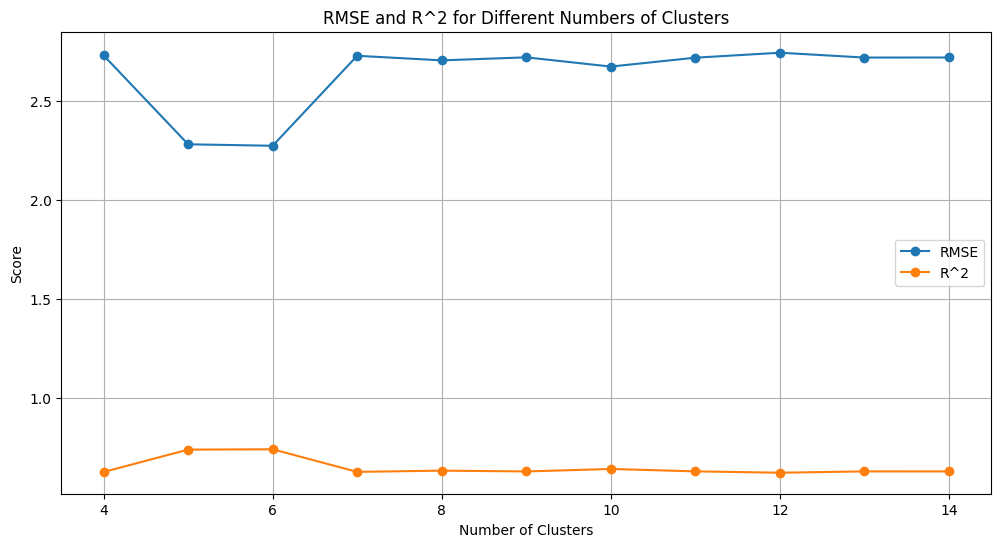

In [200]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import joblib

# Load the data
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

scaler = StandardScaler()
df[['Latitude', 'Longitude']] = scaler.fit_transform(df[['Latitude', 'Longitude']])
coords = df[['Latitude', 'Longitude']].values

# Define the range of clusters to try
cluster_range = range(4, 15)
results = []

for n_clusters in cluster_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(coords)

    # One-hot encode the cluster column
    encoder = OneHotEncoder(categories=[range(n_clusters)], sparse_output=False)
    cluster_encoded = encoder.fit_transform(df[['cluster']])
    cluster_encoded_df = pd.DataFrame(cluster_encoded, columns=[f'cluster_{i}' for i in range(n_clusters)])

    df = df.reset_index(drop=True)
    df = pd.concat([df, cluster_encoded_df], axis=1)

    features = ['day_of_week_sin', 'day_of_week_cos',
                'hour_sin', 'hour_cos', 'time_difference', 'Distance', 'Latitude', 'Longitude'] + [f'cluster_{i}' for i in range(n_clusters)]
    target = 'Ride price'

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Bayesian search
    param_grid = {
        'n_estimators': (50, 600),
        'max_depth': (1, 80),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
        'bootstrap': [True, False]
    }

    rf = RandomForestRegressor(random_state=42)
    bayes_search = BayesSearchCV(estimator=rf, search_spaces=param_grid, n_iter=50, cv=3, n_jobs=-1, random_state=42)
    bayes_search.fit(X_train, y_train)

    best_rf = bayes_search.best_estimator_

    y_pred = best_rf.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'Number of Clusters: {n_clusters}')
    print(f'Best Parameters: {bayes_search.best_params_}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R^2: {r2:.2f}')

    results.append({'n_clusters': n_clusters, 'rmse': rmse, 'r2': r2})

joblib.dump(best_rf, 'best_random_forest_model.pkl')

df_results = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
plt.plot(df_results['n_clusters'], df_results['rmse'], marker='o', label='RMSE')
plt.plot(df_results['n_clusters'], df_results['r2'], marker='o', label='R^2')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('RMSE and R^2 for Different Numbers of Clusters')
plt.legend()
plt.grid(True)
plt.show()


Number of Clusters: 2
Best Parameters: OrderedDict([('colsample_bytree', 0.6358542947724852), ('gamma', 0), ('learning_rate', 0.06620092987326917), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 519), ('subsample', 0.4)])
RMSE: 2.40
R^2: 0.71
Duplicate feature names found!
Number of Clusters: 3
Best Parameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 10), ('learning_rate', 0.27147569700827995), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 50), ('subsample', 1.0)])
RMSE: 2.70
R^2: 0.63
Duplicate feature names found!
Number of Clusters: 4
Best Parameters: OrderedDict([('colsample_bytree', 0.4), ('gamma', 3), ('learning_rate', 0.20778168534290498), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 600), ('subsample', 1.0)])
RMSE: 2.54
R^2: 0.68
Duplicate feature names found!
Number of Clusters: 5
Best Parameters: OrderedDict([('colsample_bytree', 0.4427228085200503), ('gamma', 7), ('learning_rate', 0.024420971207446927), ('max_depth', 31), (

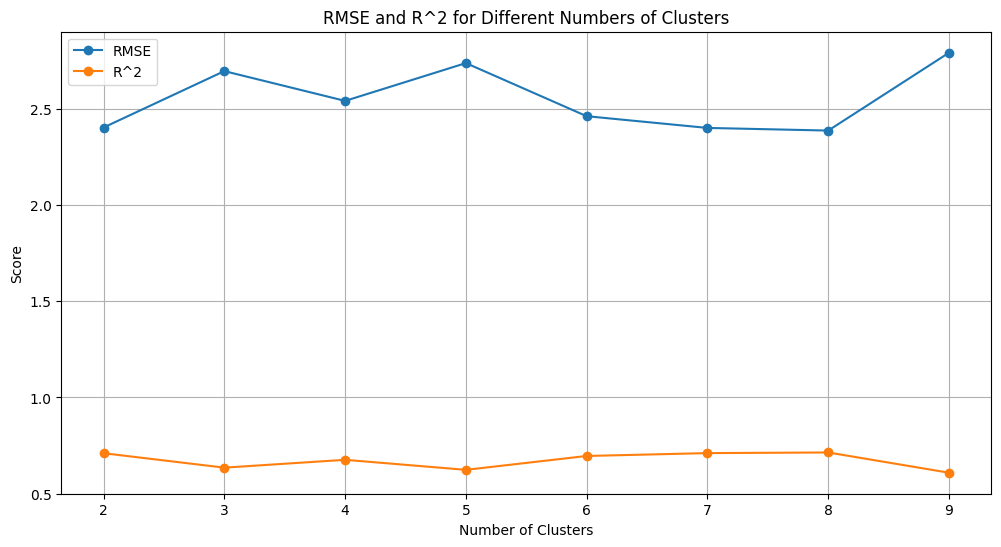

In [52]:
csv_file = '/content/drive/MyDrive/taxi_project/taxi_filtered.csv'
df = pd.read_csv(csv_file)

scaler = StandardScaler()
df[['Latitude', 'Longitude']] = scaler.fit_transform(df[['Latitude', 'Longitude']])
coords = df[['Latitude', 'Longitude']].values

# Defining the range of clusters to try
cluster_range = range(2, 10)
results = []

best_rmse = float('inf')
best_xgb = None
best_clustering = None

for n_clusters in cluster_range:
    # Perform Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    df['cluster'] = agglomerative.fit_predict(coords)

    # Save the clustering model
    joblib.dump(agglomerative, f'/content/drive/MyDrive/taxi_project/agglomerative_clusters-{n_clusters}.pkl')

    # One-hot encode the cluster column
    encoder = OneHotEncoder(categories=[range(n_clusters)], sparse_output=False)
    cluster_encoded = encoder.fit_transform(df[['cluster']])
    cluster_encoded_df = pd.DataFrame(cluster_encoded, columns=[f'cluster_{i}' for i in range(n_clusters)])

    # Reset index and concatenate the encoded cluster data
    df = df.reset_index(drop=True)
    df = pd.concat([df, cluster_encoded_df], axis=1)

    features = ['day_of_week_sin', 'day_of_week_cos',
                'hour_sin', 'hour_cos', 'time_difference', 'Distance'] + [f'cluster_{i}' for i in range(n_clusters)]
    target = 'Ride price'

    X = df[features]
    y = df[target]

    if X.columns.duplicated().any():
        print("Duplicate feature names found!")
        X = X.loc[:, ~X.columns.duplicated()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Bayesian search
    param_grid = {
        'n_estimators': (50, 600),
        'max_depth': (1, 80),
        'learning_rate': (0.001, 0.5),
        'min_child_weight': (1, 20),
        'gamma': (0, 10),
        'subsample': (0.4, 1.0),
        'colsample_bytree': (0.4, 1.0)
    }

    xgb = XGBRegressor(random_state=42)
    bayes_search = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=50, cv=3, n_jobs=-1, random_state=42)
    bayes_search.fit(X_train, y_train)

    best_estimator = bayes_search.best_estimator_

    y_pred = best_estimator.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'Number of Clusters: {n_clusters}')
    print(f'Best Parameters: {bayes_search.best_params_}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R^2: {r2:.2f}')

    results.append({'n_clusters': n_clusters, 'rmse': rmse, 'r2': r2})

    # Update the best model if the current one has a lower rmse
    if rmse < best_rmse:
        best_rmse = rmse
        best_xgb = best_estimator
        best_clustering = agglomerative

# Save the best models
joblib.dump(best_xgb, '/content/drive/MyDrive/taxi_project/best_xgboost.pkl')
joblib.dump(best_clustering, '/content/drive/MyDrive/taxi_project/best_agglomerative.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/taxi_project/scaler.pkl')

# Plot the results
df_results = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
plt.plot(df_results['n_clusters'], df_results['rmse'], marker='o', label='RMSE')
plt.plot(df_results['n_clusters'], df_results['r2'], marker='o', label='R^2')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('RMSE and R^2 for Different Numbers of Clusters')
plt.legend()
plt.grid(True)
plt.show()


## Predicting price given pickup address and drop-off address (using https://openrouteservice.org)

We will use ORS services to determine variables such as **time difference** and **distance**.

In [136]:
def get_route_info(pickup_address, dropoff_address):
    (pickup_lat, pickup_lon) = get_coordinates(pickup_address)
    (dropoff_lat, dropoff_lon) = get_coordinates(dropoff_address)

    body = {
        "locations": [[pickup_lon, pickup_lat], [dropoff_lon, dropoff_lat]],
        "metrics": ["duration", "distance"]
    }

    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
        'Authorization': ORS_API_KEY,
        'Content-Type': 'application/json; charset=utf-8'
    }

    call = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)

    if call.status_code == 200:
        response = call.json()
        duration = response['durations'][0][1] / 60  # Convert duration to minutes
        distance = response['distances'][0][1] / 1000  # Convert distance to kilometers
        return duration, distance
    else:
        print("Error:", call.status_code, call.reason)
        print(call.text)
        return None, None

pickup_address = "Tauragnu 11, Kaunas"
dropoff_address = "Kreves prospektas 25, Kaunas"
order_time = pd.Timestamp('2024-07-19 19:55:00')

time_difference, distance = get_route_info(pickup_address, dropoff_address)


# Predicting Ride Price with the Best XGBoost Model

In [141]:
# Loading model, clustering with optimal number of clusters, and used scakler
best_xgb = joblib.load('/content/drive/MyDrive/taxi_project/best_xgboost.pkl')
scaler = joblib.load('/content/drive/MyDrive/taxi_project/scaler.pkl')

new_data = pd.DataFrame({
    'Order time': ['2024-07-19 19:50:00'],
    'Latitude': pickup_lat,
    'Longitude': pickup_lon,
    'time_difference': time_difference,  #  value in minutes
    'Distance': distance  #  distance in kilometers
})

I encountered an issue where I couldn't directly assign new addresses to clusters using the trained Agglomerative Clustering model. Since 8 clusters performed the best in the training I used cluster_num=8 and resolved this by assigning new addresses to the cluster whose centroid is nearest to the address's coordinates.

In [142]:
new_data

,Order time,Latitude,Longitude,time_difference,Distance
0,2024-07-19 19:50:00,54.928089,23.887013,13.958667,6.07582


In [143]:
centroids = joblib.load('/content/drive/MyDrive/taxi_project/centroids.pkl')
scaler = joblib.load('/content/drive/MyDrive/taxi_project/scaler.pkl')

# Normalize the new data
new_data[['Latitude', 'Longitude']] = scaler.transform(new_data[['Latitude', 'Longitude']])

# Compute distances to centroids
distances = euclidean_distances(new_data[['Latitude', 'Longitude']], centroids)
closest_cluster = np.argmin(distances, axis=1)

print("Cluster labels for new data points:")
print(closest_cluster)

Cluster labels for new data points:
[3]


In [144]:
features = ['day_of_week_sin', 'day_of_week_cos',
            'hour_sin', 'hour_cos', 'time_difference', 'Distance'] + [f'cluster_{i}' for i in range(8)]
feature_vector = np.zeros(len(features))
new_data=extract_date_features(new_data)
feature_vector[features.index('day_of_week_sin')] = new_data['day_of_week_sin'].values[0]
feature_vector[features.index('day_of_week_cos')] = new_data['day_of_week_cos'].values[0]
feature_vector[features.index('hour_sin')] = new_data['hour_sin'].values[0]
feature_vector[features.index('hour_cos')] = new_data['hour_cos'].values[0]
feature_vector[features.index('time_difference')] = new_data['time_difference'].values[0]
feature_vector[features.index('Distance')] = new_data['Distance'].values[0]

# Set the appropriate cluster feature to 1
cluster_feature_name = f'cluster_{closest_cluster}'
if cluster_feature_name in features:
    feature_vector[features.index(cluster_feature_name)] = True

# Ensure all other cluster features are set to 0
for i in range(8):
    if i != closest_cluster:
        feature_vector[features.index(f'cluster_{i}')] = False

# Convert the feature vector to the format expected by the model
feature_vector = feature_vector.reshape(1, -1)

# Make prediction
predicted_price = best_xgb.predict(feature_vector)

print(f"Predicted ride price: ${predicted_price[0]:.2f}")

Predicted ride price: $4.85


# Future work

* Expand Database: Gather a larger dataset of taxi fares to improve model performance and generalizability.

* Advanced Models: Explore and test more complex models, including deep learning techniques.

* Enhance Features: Develop additional features and integrate more detailed data for better predictions.

* Real-Time Data: Implement live data updates, such as events and their locations, to enable real-time predictions.

